Dataset and DataLoading

In [171]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import optim
from torch import nn
from PIL import Image


In [172]:


training_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
testing_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)


train_loader=DataLoader(training_data,batch_size=100,shuffle=True)
test_loader=DataLoader(testing_data,batch_size=100,shuffle=True)


In [173]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Data visualization

In [174]:
example=next(iter(train_loader))
sample,label=example

print(len(example))
print(sample[0].shape)
print(label[0].item())


2
torch.Size([1, 28, 28])
4


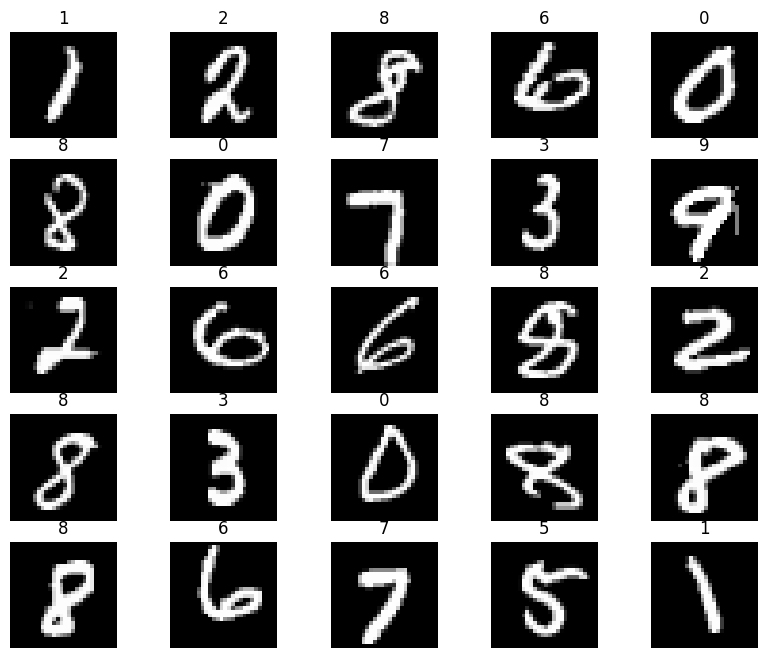

In [175]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



CNN Model

In [176]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,  # 1 for grey scale, 3 for RGB  , #n for n number of features maps
                out_channels=16,    # number of feature maps
                kernel_size=5,         # kernel size
                stride=1,
                padding=2,
                #output size=   28(inputsise) - 5(kernel) + 2*2(padding) / 1(stride) +1  result 16 feature maps of 28x28
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),    # 28x28 reduced to 14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),    # 16 feature maps with size 14x14 produced by filter , 32 feature of 14x14
            nn.ReLU(),
            nn.MaxPool2d(2),  # (generated feature map of size= (14-5+4) /2 )  After pooling = 7x7
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x,1)
        output = self.out(x)
        return output    # return x for visualization

In [177]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
num_epochs = 10
batch_size=100

Training the model

In [178]:
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)

    model.train()

    for batch,(X,y) in enumerate(dataloader):
        X=X.to(device)
        y=y.to(device)
        #forward pass
        y_pred=model(X)
        #loss
        loss=loss_fn(y_pred,y)
        #backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        if batch % 100 == 0:
                loss, current = loss.item(), batch * batch_size + len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [179]:

for z in range(num_epochs):
    print(f"Epoch {z+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)

print("Done!")


Epoch 1
-------------------------------
loss: 2.309003  [  100/60000]
loss: 0.071153  [10100/60000]
loss: 0.064889  [20100/60000]
loss: 0.056734  [30100/60000]
loss: 0.076061  [40100/60000]
loss: 0.060047  [50100/60000]
Epoch 2
-------------------------------
loss: 0.036140  [  100/60000]
loss: 0.101599  [10100/60000]
loss: 0.123205  [20100/60000]
loss: 0.183495  [30100/60000]
loss: 0.102385  [40100/60000]
loss: 0.053569  [50100/60000]
Epoch 3
-------------------------------
loss: 0.022032  [  100/60000]
loss: 0.011094  [10100/60000]
loss: 0.049826  [20100/60000]
loss: 0.006845  [30100/60000]
loss: 0.012290  [40100/60000]
loss: 0.045682  [50100/60000]
Epoch 4
-------------------------------
loss: 0.065050  [  100/60000]
loss: 0.116719  [10100/60000]
loss: 0.015657  [20100/60000]
loss: 0.049103  [30100/60000]
loss: 0.029698  [40100/60000]
loss: 0.019647  [50100/60000]
Epoch 5
-------------------------------
loss: 0.013294  [  100/60000]
loss: 0.007907  [10100/60000]
loss: 0.012222  [201

In [180]:
def test():
    # Test the model
    best_loss=float("inf")
    test_loss=0;
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output = model(images)
            test_loss +=loss_fn(test_output,labels).item()
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            if test_loss<best_loss:
                best_loss=test_loss
                torch.save(model.state_dict(),"model_weight.pth")

            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


test()
print()

Test Accuracy of the model on the 10000 test images: 0.98



In [186]:
model.load_state_dict(torch.load('model_weight.pth'))
torch.save(model,'model.pth')
model.eval()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [187]:
transform = transforms.Compose([
    transforms.Grayscale(),# Ensure the image is in grayscale if needed
    transforms.Resize((28, 28)),  # Resize to the same size as the training images
    transforms.ToTensor(), # Convert to tensor
])


In [189]:
# Load and preprocess the test image
image = Image.open('test_image.png')
image = transform(image).unsqueeze(0)

In [190]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
image = image.to(device)

In [191]:
# Classify the image
with torch.no_grad():
    output = model(image)
    predicted_class = torch.argmax(output, dim=1)

print(f'Predicted class: {predicted_class.item()}')

Predicted class: 2
